In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day_str: str) -> str:
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [6]:

def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 116014
New cases registered today: 4497
New cases registered today in %: 4.03
Doubling time in the last five days: 17.1
Doubling time yesterday: 15.7
Trend of new cases (in %) in the last 5 days: 22.53


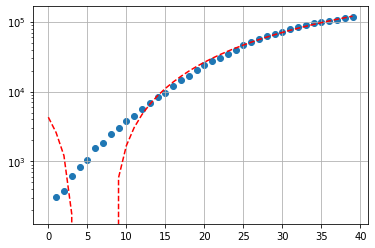

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1563
New cases registered today: 66
New cases registered today in %: 4.41
Doubling time in the last five days: 18.3
Doubling time yesterday: 12.4
Trend of new cases (in %) in the last 5 days: 20.88


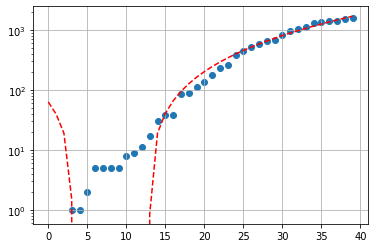

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.7966
Total cases up to today: 310
New cases registered today: 11
New cases registered today in %: 3.68
Doubling time in the last five days: 22.6
Doubling time yesterday: 13.0
Trend of new cases (in %) in the last 5 days: 16.54


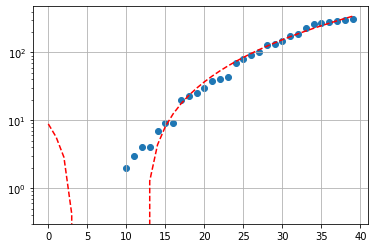

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.5498
Total cases up to today: 166
New cases registered today: 26
New cases registered today in %: 18.57
Doubling time in the last five days: 7.0
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 64.36


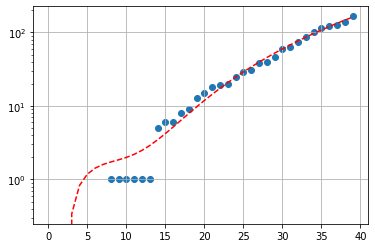

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 2.0821
Total cases up to today: 669
New cases registered today: 23
New cases registered today in %: 3.56
Doubling time in the last five days: 23.2
Doubling time yesterday: 14.9
Trend of new cases (in %) in the last 5 days: 16.15


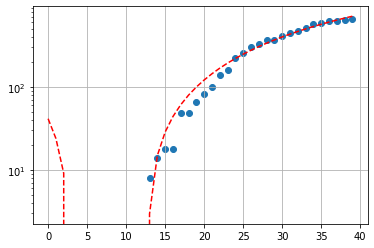

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 1.349
Total cases up to today: 418
New cases registered today: 6
New cases registered today in %: 1.46
Doubling time in the last five days: 19.5
Doubling time yesterday: 11.4
Trend of new cases (in %) in the last 5 days: 19.43


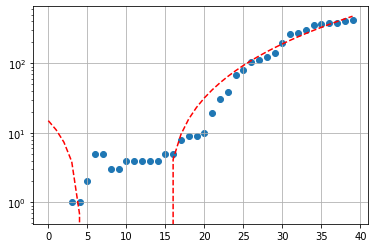

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 261
New cases registered today: 15
New cases registered today in %: 6.1
Doubling time in the last five days: 13.5
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 29.21


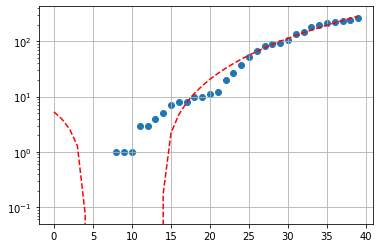

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.621
Total cases up to today: 124
New cases registered today: 6
New cases registered today in %: 5.08
Doubling time in the last five days: 8.9
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 47.62


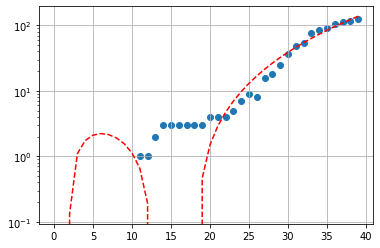

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.3696
Total cases up to today: 137
New cases registered today: 9
New cases registered today in %: 7.03
Doubling time in the last five days: 23.2
Doubling time yesterday: 18.4
Trend of new cases (in %) in the last 5 days: 16.1


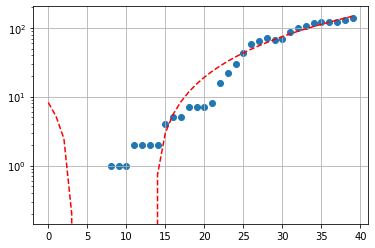

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1559
New cases registered today: 80
New cases registered today in %: 5.41
Doubling time in the last five days: 13.9
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 28.42


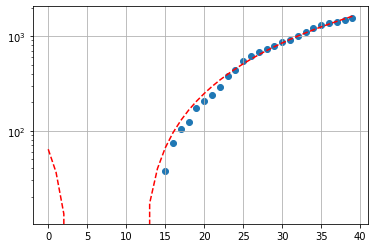

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 731
New cases registered today: 42
New cases registered today in %: 6.1
Doubling time in the last five days: 19.5
Doubling time yesterday: 15.8
Trend of new cases (in %) in the last 5 days: 19.44


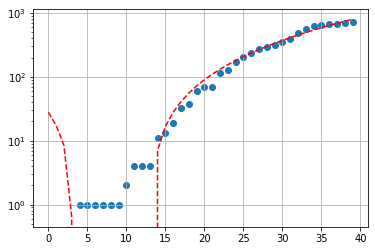

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.414
Total cases up to today: 150
New cases registered today: 4
New cases registered today in %: 2.74
Doubling time in the last five days: 17.5
Doubling time yesterday: 16.3
Trend of new cases (in %) in the last 5 days: 21.95


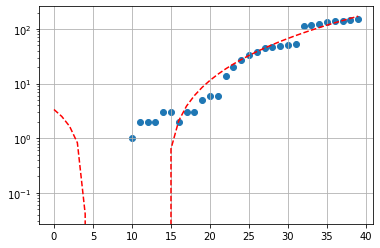

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.2852
Total cases up to today: 203
New cases registered today: 9
New cases registered today in %: 4.64
Doubling time in the last five days: 20.2
Doubling time yesterday: 15.0
Trend of new cases (in %) in the last 5 days: 18.71


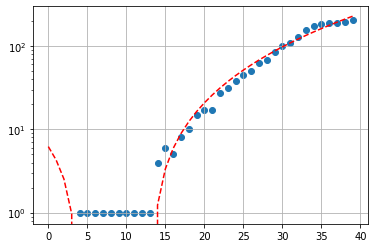

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.6038
Total cases up to today: 106
New cases registered today: 12
New cases registered today in %: 12.77
Doubling time in the last five days: 21.2
Doubling time yesterday: 44.8
Trend of new cases (in %) in the last 5 days: 17.78


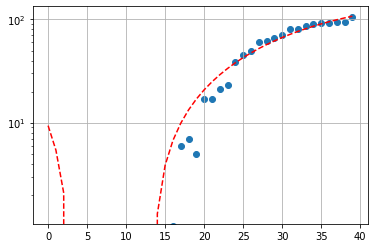

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.3936
Total cases up to today: 218
New cases registered today: 11
New cases registered today in %: 5.31
Doubling time in the last five days: 24.3
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 15.34


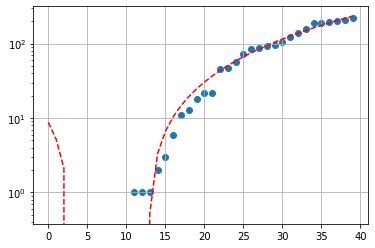

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.3341
Total cases up to today: 54
New cases registered today: 6
New cases registered today in %: 12.5
Doubling time in the last five days: 10.6
Doubling time yesterday: 16.7
Trend of new cases (in %) in the last 5 days: 38.46


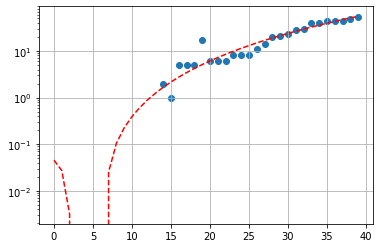

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 2517
New cases registered today: 223
New cases registered today in %: 9.72
Doubling time in the last five days: 8.2
Doubling time yesterday: 8.6
Trend of new cases (in %) in the last 5 days: 52.82


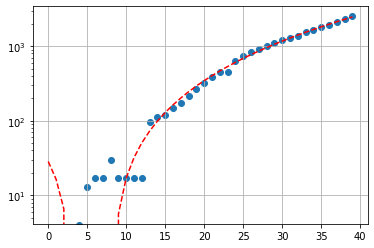

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.8028
Total cases up to today: 340
New cases registered today: 50
New cases registered today in %: 17.24
Doubling time in the last five days: 7.1
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 63.46


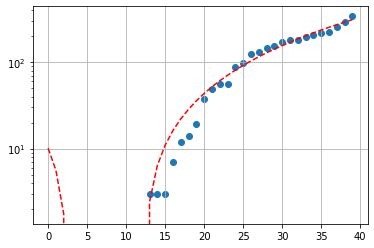

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.3039
Total cases up to today: 85
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 2.5
Doubling time yesterday: 2.5
Trend of new cases (in %) in the last 5 days: 304.76


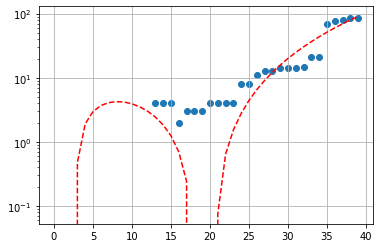

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.2857
Total cases up to today: 264
New cases registered today: 9
New cases registered today in %: 3.53
Doubling time in the last five days: 11.8
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 34.01


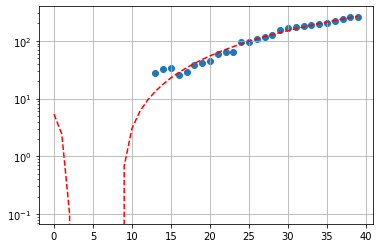

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.4596
Total cases up to today: 1428
New cases registered today: 149
New cases registered today in %: 11.65
Doubling time in the last five days: 7.5
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 59.02


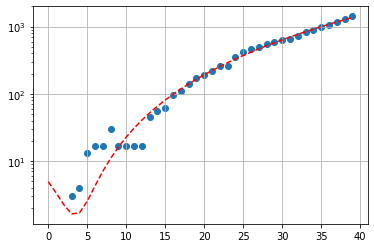

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.3621
Total cases up to today: 400
New cases registered today: 15
New cases registered today in %: 3.9
Doubling time in the last five days: 16.2
Doubling time yesterday: 15.3
Trend of new cases (in %) in the last 5 days: 23.84


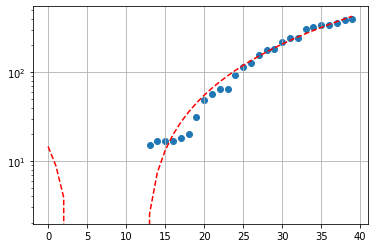

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 0
New cases registered today: 0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


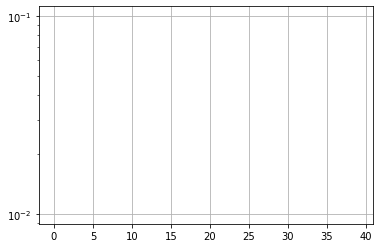

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 2.3177
Total cases up to today: 2339
New cases registered today: 114
New cases registered today in %: 5.12
Doubling time in the last five days: 11.8
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 34.19


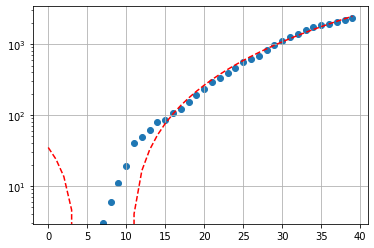

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 1.0564
Total cases up to today: 368
New cases registered today: 27
New cases registered today in %: 7.92
Doubling time in the last five days: 17.0
Doubling time yesterday: 17.9
Trend of new cases (in %) in the last 5 days: 22.67


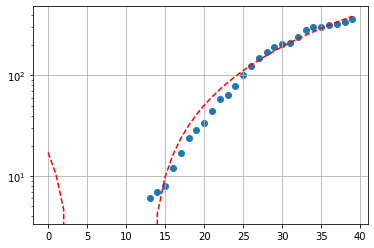

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 3.5642
Total cases up to today: 2498
New cases registered today: 82
New cases registered today in %: 3.39
Doubling time in the last five days: 19.6
Doubling time yesterday: 15.2
Trend of new cases (in %) in the last 5 days: 19.29


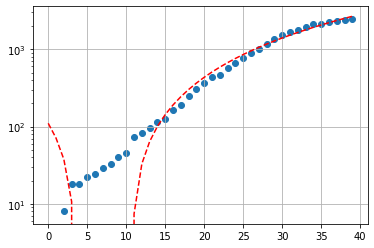

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 4.6402
Total cases up to today: 2083
New cases registered today: 34
New cases registered today in %: 1.66
Doubling time in the last five days: 24.6
Doubling time yesterday: 22.1
Trend of new cases (in %) in the last 5 days: 15.15


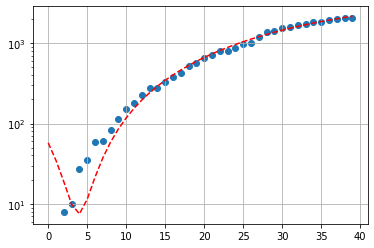

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 9.8027
Total cases up to today: 2811
New cases registered today: 46
New cases registered today in %: 1.66
Doubling time in the last five days: 27.2
Doubling time yesterday: 23.8
Trend of new cases (in %) in the last 5 days: 13.58


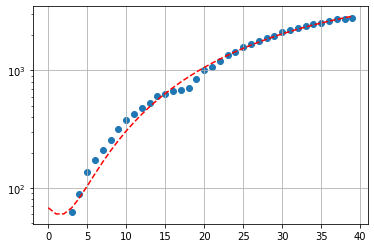

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.676
Total cases up to today: 656
New cases registered today: 29
New cases registered today in %: 4.63
Doubling time in the last five days: 20.3
Doubling time yesterday: 18.7
Trend of new cases (in %) in the last 5 days: 18.63


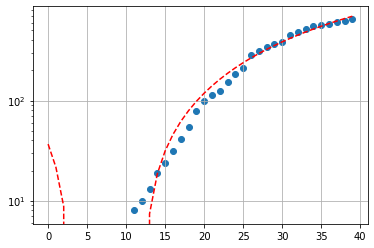

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 5.2584
Total cases up to today: 2800
New cases registered today: 135
New cases registered today in %: 5.07
Doubling time in the last five days: 13.0
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 30.48


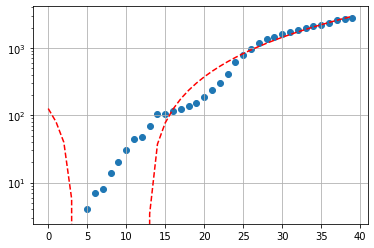

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 4.4865
Total cases up to today: 1511
New cases registered today: 55
New cases registered today in %: 3.78
Doubling time in the last five days: 32.2
Doubling time yesterday: 36.2
Trend of new cases (in %) in the last 5 days: 11.35


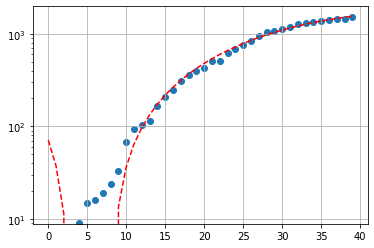

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 1873
New cases registered today: 83
New cases registered today in %: 4.64
Doubling time in the last five days: 14.3
Doubling time yesterday: 15.4
Trend of new cases (in %) in the last 5 days: 27.33


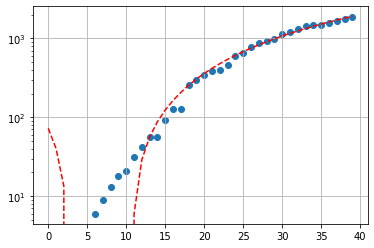

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.7947
Total cases up to today: 111
New cases registered today: 1
New cases registered today in %: 0.91
Doubling time in the last five days: 17.4
Doubling time yesterday: 13.4
Trend of new cases (in %) in the last 5 days: 21.98


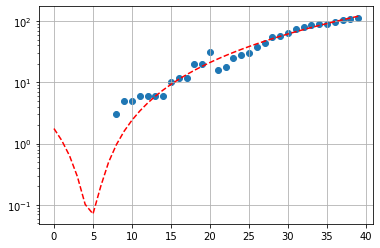

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.4485
Total cases up to today: 452
New cases registered today: 11
New cases registered today in %: 2.49
Doubling time in the last five days: 16.9
Doubling time yesterday: 17.6
Trend of new cases (in %) in the last 5 days: 22.83


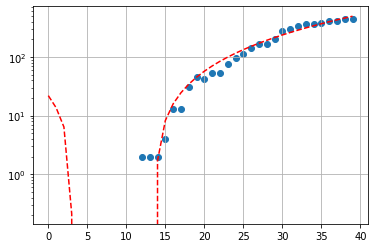

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 2.6802
Total cases up to today: 629
New cases registered today: 31
New cases registered today in %: 5.18
Doubling time in the last five days: 12.4
Doubling time yesterday: 12.4
Trend of new cases (in %) in the last 5 days: 32.14


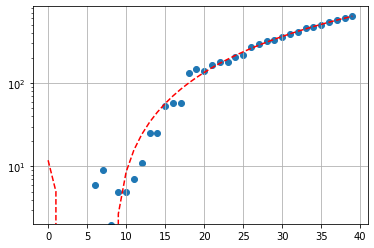

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.2814
Total cases up to today: 681
New cases registered today: 40
New cases registered today in %: 6.24
Doubling time in the last five days: 14.5
Doubling time yesterday: 18.2
Trend of new cases (in %) in the last 5 days: 27.05


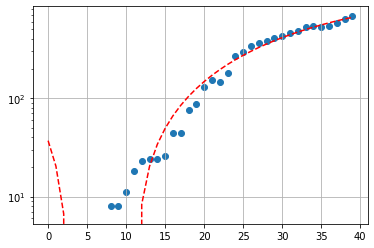

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 3575
New cases registered today: 161
New cases registered today in %: 4.72
Doubling time in the last five days: 12.2
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 32.85


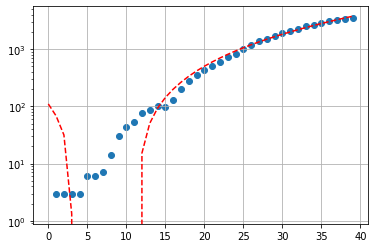

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.718
Total cases up to today: 354
New cases registered today: 20
New cases registered today in %: 5.99
Doubling time in the last five days: 10.2
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 40.48


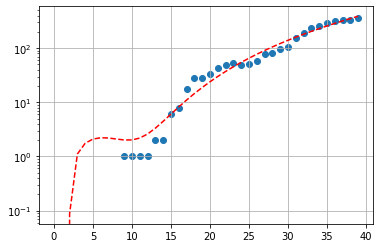

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.5288
Total cases up to today: 304
New cases registered today: 24
New cases registered today in %: 8.57
Doubling time in the last five days: 14.4
Doubling time yesterday: 13.1
Trend of new cases (in %) in the last 5 days: 27.2


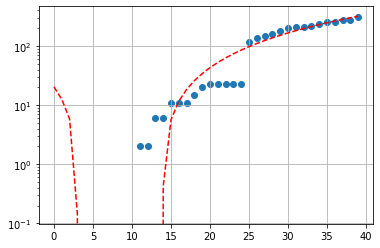

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 1.1943
Total cases up to today: 188
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 3.8
Doubling time yesterday: 3.1
Trend of new cases (in %) in the last 5 days: 147.37


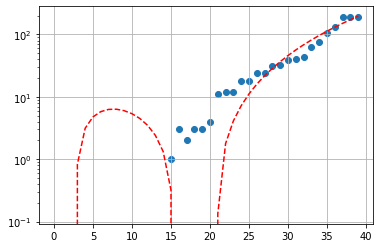

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.5749
Total cases up to today: 2503
New cases registered today: 110
New cases registered today in %: 4.6
Doubling time in the last five days: 13.7
Doubling time yesterday: 13.2
Trend of new cases (in %) in the last 5 days: 28.69


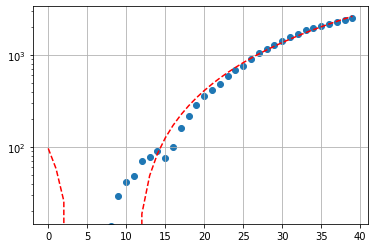

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.7084
Total cases up to today: 226
New cases registered today: 7
New cases registered today in %: 3.2
Doubling time in the last five days: 14.9
Doubling time yesterday: 8.3
Trend of new cases (in %) in the last 5 days: 26.26


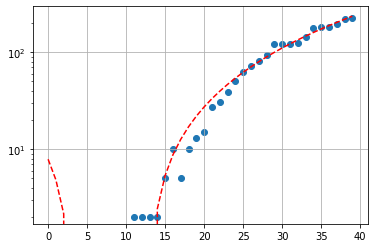

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 1990
New cases registered today: 122
New cases registered today in %: 6.53
Doubling time in the last five days: 25.0
Doubling time yesterday: 19.8
Trend of new cases (in %) in the last 5 days: 14.9


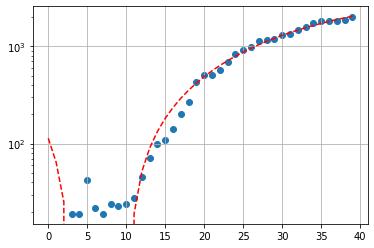

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 1.3881
Total cases up to today: 1180
New cases registered today: 27
New cases registered today in %: 2.34
Doubling time in the last five days: 24.8
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 15.01


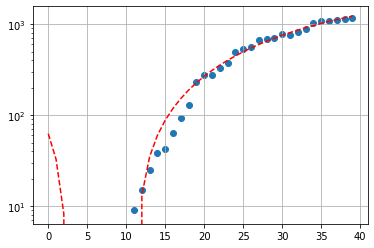

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 1.0366
Total cases up to today: 223
New cases registered today: 3
New cases registered today in %: 1.36
Doubling time in the last five days: -72.0
Doubling time yesterday: -49.4
Trend of new cases (in %) in the last 5 days: -4.7


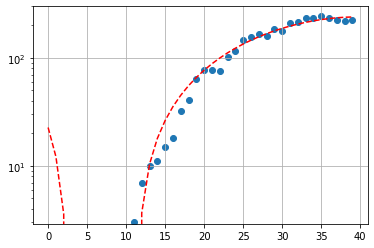

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 1.4635
Total cases up to today: 323
New cases registered today: 73
New cases registered today in %: 29.2
Doubling time in the last five days: 10.6
Doubling time yesterday: 52.4
Trend of new cases (in %) in the last 5 days: 38.63


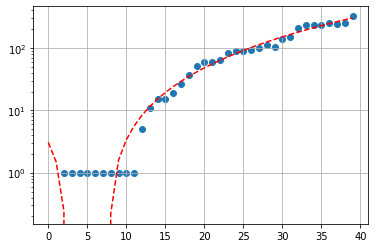

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 0.9449
Total cases up to today: 264
New cases registered today: 19
New cases registered today in %: 7.76
Doubling time in the last five days: 34.8
Doubling time yesterday: 30.9
Trend of new cases (in %) in the last 5 days: 10.46


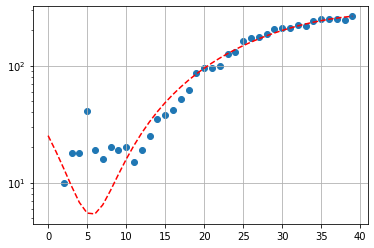

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 46492
New cases registered today: 1421
New cases registered today in %: 3.15
Doubling time in the last five days: 23.5
Doubling time yesterday: 21.2
Trend of new cases (in %) in the last 5 days: 15.92


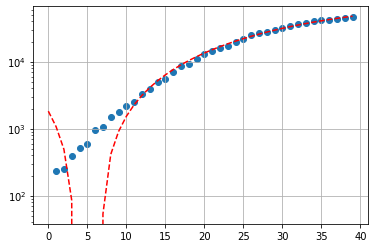

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 8.3924
Total cases up to today: 9315
New cases registered today: 144
New cases registered today in %: 1.57
Doubling time in the last five days: 39.2
Doubling time yesterday: 36.9
Trend of new cases (in %) in the last 5 days: 9.24


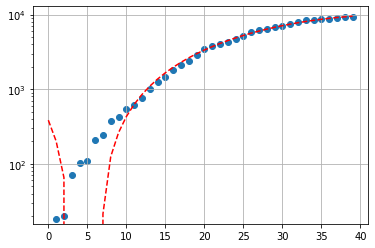

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 7.1408
Total cases up to today: 9014
New cases registered today: 257
New cases registered today in %: 2.93
Doubling time in the last five days: 29.4
Doubling time yesterday: 26.4
Trend of new cases (in %) in the last 5 days: 12.49


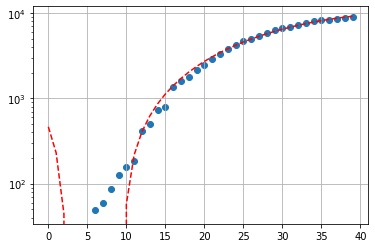

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 2.0927
Total cases up to today: 1256
New cases registered today: 51
New cases registered today in %: 4.23
Doubling time in the last five days: 16.2
Doubling time yesterday: 12.0
Trend of new cases (in %) in the last 5 days: 23.87


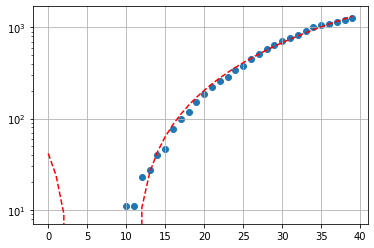

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 11.3999
Total cases up to today: 4097
New cases registered today: 123
New cases registered today in %: 3.1
Doubling time in the last five days: 40.6
Doubling time yesterday: 35.6
Trend of new cases (in %) in the last 5 days: 8.9


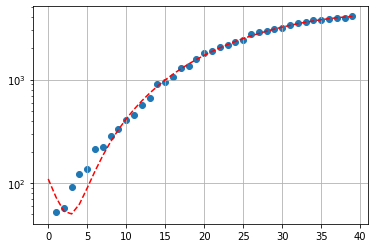

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 4.6988
Total cases up to today: 1594
New cases registered today: 42
New cases registered today in %: 2.71
Doubling time in the last five days: 24.2
Doubling time yesterday: 21.0
Trend of new cases (in %) in the last 5 days: 15.42


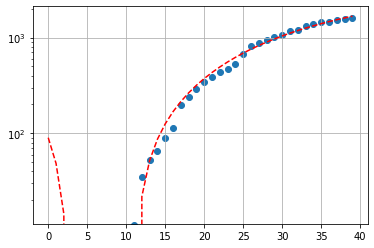

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 9.6539
Total cases up to today: 2214
New cases registered today: 25
New cases registered today in %: 1.14
Doubling time in the last five days: 47.1
Doubling time yesterday: 45.7
Trend of new cases (in %) in the last 5 days: 7.63


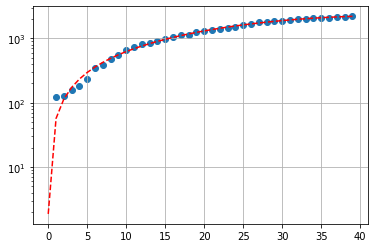

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 4.5661
Total cases up to today: 1884
New cases registered today: 102
New cases registered today in %: 5.72
Doubling time in the last five days: 17.8
Doubling time yesterday: 18.9
Trend of new cases (in %) in the last 5 days: 21.55


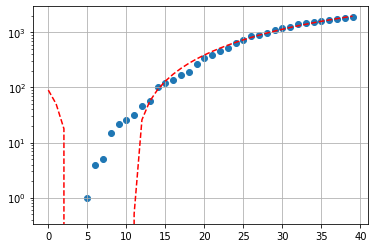

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 3.2288
Total cases up to today: 10391
New cases registered today: 387
New cases registered today in %: 3.87
Doubling time in the last five days: 15.7
Doubling time yesterday: 13.8
Trend of new cases (in %) in the last 5 days: 24.76


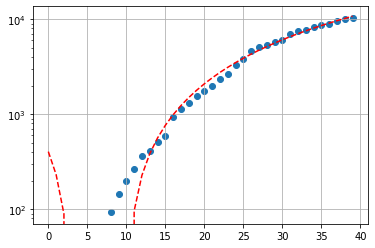

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 3.1927
Total cases up to today: 2774
New cases registered today: 141
New cases registered today in %: 5.36
Doubling time in the last five days: 17.1
Doubling time yesterday: 14.9
Trend of new cases (in %) in the last 5 days: 22.47


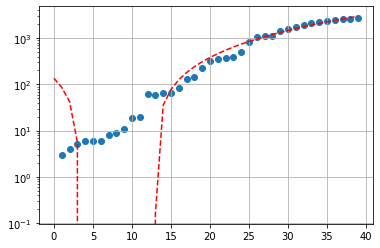

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 4.2595
Total cases up to today: 2331
New cases registered today: 46
New cases registered today in %: 2.01
Doubling time in the last five days: 20.8
Doubling time yesterday: 17.6
Trend of new cases (in %) in the last 5 days: 18.09


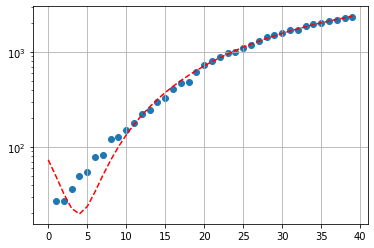

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 2.9597
Total cases up to today: 537
New cases registered today: 20
New cases registered today in %: 3.87
Doubling time in the last five days: 14.4
Doubling time yesterday: 12.1
Trend of new cases (in %) in the last 5 days: 27.25


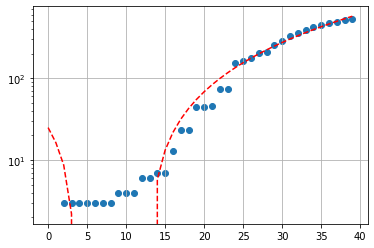

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 1.219
Total cases up to today: 1085
New cases registered today: 83
New cases registered today in %: 8.28
Doubling time in the last five days: 12.0
Doubling time yesterday: 13.0
Trend of new cases (in %) in the last 5 days: 33.62


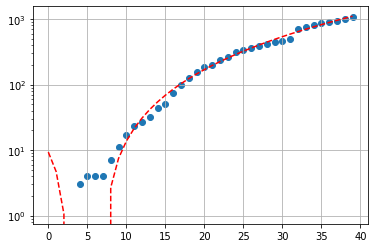

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 4140
New cases registered today: 129
New cases registered today in %: 3.22
Doubling time in the last five days: 20.5
Doubling time yesterday: 18.1
Trend of new cases (in %) in the last 5 days: 18.39


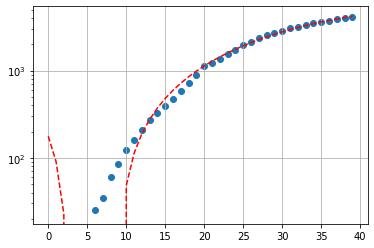

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 2.6639
Total cases up to today: 1263
New cases registered today: 52
New cases registered today in %: 4.29
Doubling time in the last five days: 16.1
Doubling time yesterday: 13.9
Trend of new cases (in %) in the last 5 days: 23.95


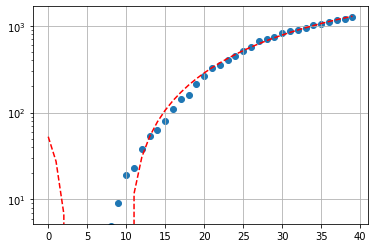

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 1.1077
Total cases up to today: 232
New cases registered today: 5
New cases registered today in %: 2.2
Doubling time in the last five days: 13.4
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 29.61


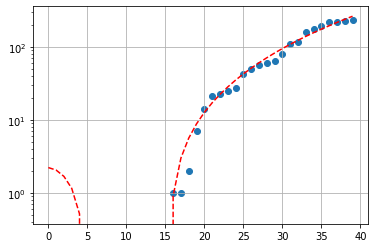

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.7043
Total cases up to today: 298
New cases registered today: 14
New cases registered today in %: 4.93
Doubling time in the last five days: 18.1
Doubling time yesterday: 21.1
Trend of new cases (in %) in the last 5 days: 21.14


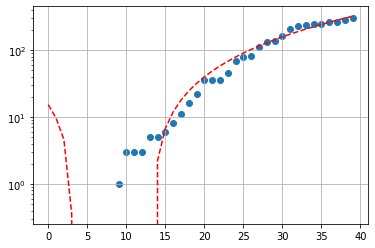

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 1.7591
Total cases up to today: 561
New cases registered today: 28
New cases registered today in %: 5.25
Doubling time in the last five days: 21.1
Doubling time yesterday: 22.5
Trend of new cases (in %) in the last 5 days: 17.86


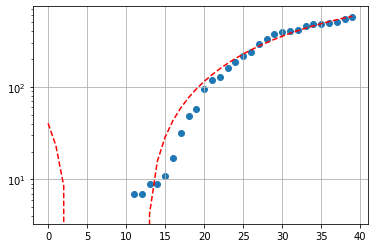

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 4.9513
Total cases up to today: 1786
New cases registered today: 30
New cases registered today in %: 1.71
Doubling time in the last five days: 27.8
Doubling time yesterday: 22.7
Trend of new cases (in %) in the last 5 days: 13.25


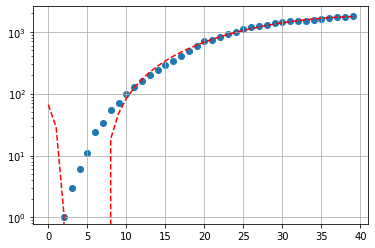

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 164
New cases registered today: 11
New cases registered today in %: 7.19
Doubling time in the last five days: 10.3
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 40.17


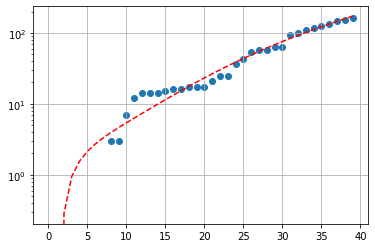

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.6633
Total cases up to today: 149
New cases registered today: 7
New cases registered today in %: 4.93
Doubling time in the last five days: 10.8
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 37.96


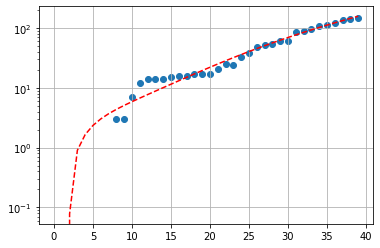

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.1748
Total cases up to today: 15
New cases registered today: 4
New cases registered today in %: 36.36
Doubling time in the last five days: 6.8
Doubling time yesterday: -20.7
Trend of new cases (in %) in the last 5 days: 66.67


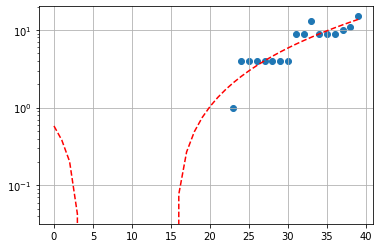

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 10701
New cases registered today: 566
New cases registered today in %: 5.58
Doubling time in the last five days: 12.0
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 33.56


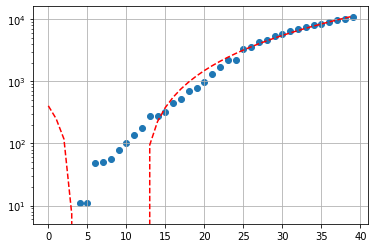

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 3.4946
Total cases up to today: 1491
New cases registered today: 63
New cases registered today in %: 4.41
Doubling time in the last five days: 20.1
Doubling time yesterday: 19.6
Trend of new cases (in %) in the last 5 days: 18.8


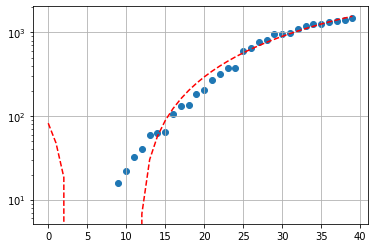

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 2.4137
Total cases up to today: 523
New cases registered today: 22
New cases registered today in %: 4.39
Doubling time in the last five days: 7.4
Doubling time yesterday: 7.6
Trend of new cases (in %) in the last 5 days: 59.45


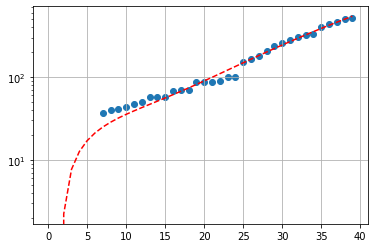

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 3.0355
Total cases up to today: 542
New cases registered today: 19
New cases registered today in %: 3.63
Doubling time in the last five days: 16.4
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 23.46


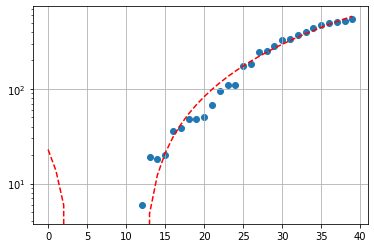

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 1.4429
Total cases up to today: 850
New cases registered today: 24
New cases registered today in %: 2.91
Doubling time in the last five days: 9.5
Doubling time yesterday: 8.8
Trend of new cases (in %) in the last 5 days: 43.82


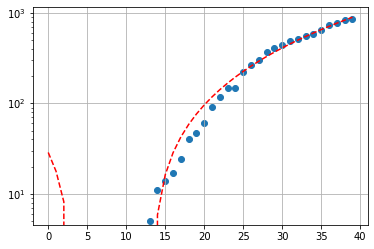

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 2.5125
Total cases up to today: 930
New cases registered today: 28
New cases registered today in %: 3.1
Doubling time in the last five days: 11.8
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 34.01


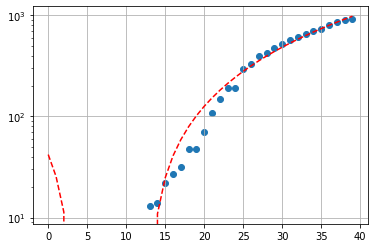

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 2.3246
Total cases up to today: 5295
New cases registered today: 304
New cases registered today in %: 6.09
Doubling time in the last five days: 11.7
Doubling time yesterday: 11.2
Trend of new cases (in %) in the last 5 days: 34.63


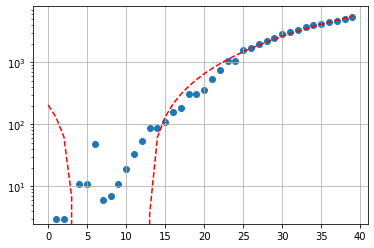

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 3.1629
Total cases up to today: 505
New cases registered today: 61
New cases registered today in %: 13.74
Doubling time in the last five days: 9.2
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 45.95


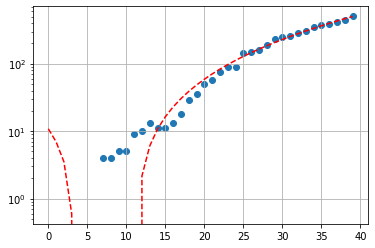

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 3.2496
Total cases up to today: 565
New cases registered today: 45
New cases registered today in %: 8.65
Doubling time in the last five days: 12.3
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 32.63


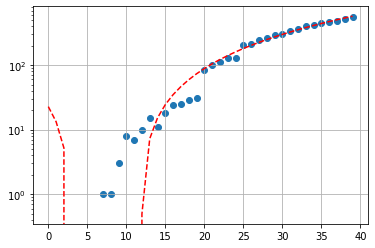

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 2152
New cases registered today: 100
New cases registered today in %: 4.87
Doubling time in the last five days: 9.3
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 45.11


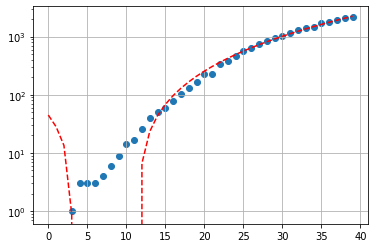

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.588
Total cases up to today: 741
New cases registered today: 41
New cases registered today in %: 5.86
Doubling time in the last five days: 9.7
Doubling time yesterday: 8.7
Trend of new cases (in %) in the last 5 days: 43.05


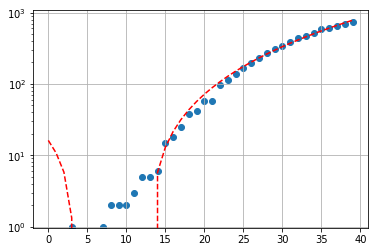

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.3286
Total cases up to today: 129
New cases registered today: 3
New cases registered today in %: 2.38
Doubling time in the last five days: 12.6
Doubling time yesterday: 12.7
Trend of new cases (in %) in the last 5 days: 31.63


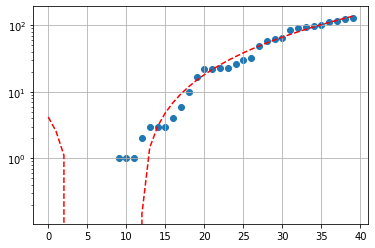

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.549
Total cases up to today: 218
New cases registered today: 10
New cases registered today in %: 4.81
Doubling time in the last five days: 9.6
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 43.42


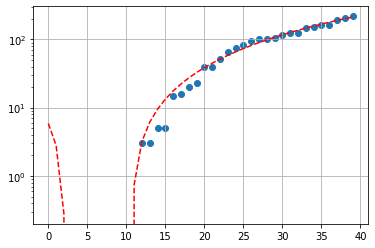

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 0.8384
Total cases up to today: 527
New cases registered today: 25
New cases registered today in %: 4.98
Doubling time in the last five days: 10.3
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 39.79


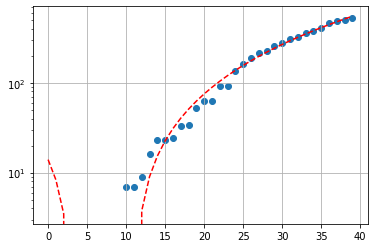

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.4476
Total cases up to today: 359
New cases registered today: 6
New cases registered today in %: 1.7
Doubling time in the last five days: 8.5
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 50.21


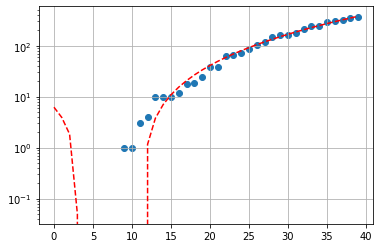

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.3051
Total cases up to today: 178
New cases registered today: 15
New cases registered today in %: 9.2
Doubling time in the last five days: 5.9
Doubling time yesterday: 6.2
Trend of new cases (in %) in the last 5 days: 79.8


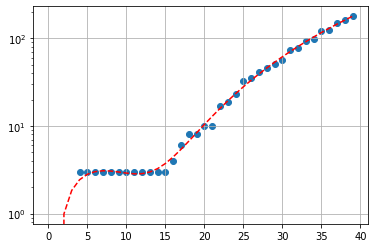

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 825
New cases registered today: 31
New cases registered today in %: 3.9
Doubling time in the last five days: 13.5
Doubling time yesterday: 14.4
Trend of new cases (in %) in the last 5 days: 29.31


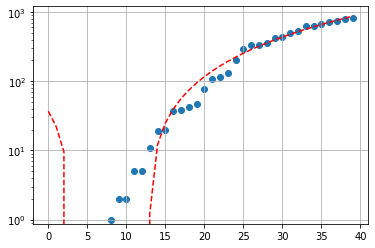

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.2391
Total cases up to today: 134
New cases registered today: 8
New cases registered today in %: 6.35
Doubling time in the last five days: 12.7
Doubling time yesterday: 13.2
Trend of new cases (in %) in the last 5 days: 31.37


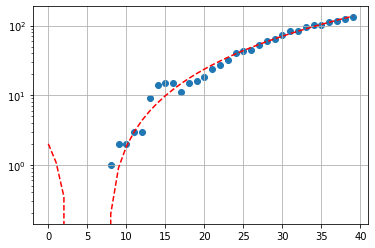

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.3972
Total cases up to today: 62
New cases registered today: 2
New cases registered today in %: 3.33
Doubling time in the last five days: 41.2
Doubling time yesterday: 50.2
Trend of new cases (in %) in the last 5 days: 8.77


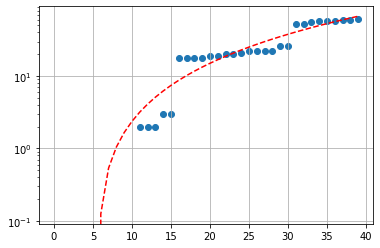

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.1182
Total cases up to today: 19
New cases registered today: 1
New cases registered today in %: 5.56
Doubling time in the last five days: 4.6
Doubling time yesterday: 5.0
Trend of new cases (in %) in the last 5 days: 111.11


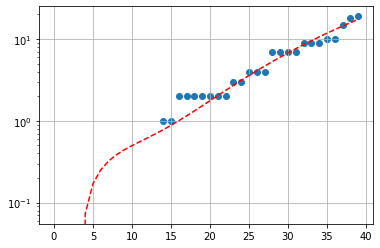

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 1.6421
Total cases up to today: 547
New cases registered today: 19
New cases registered today in %: 3.6
Doubling time in the last five days: 12.5
Doubling time yesterday: 13.3
Trend of new cases (in %) in the last 5 days: 31.81


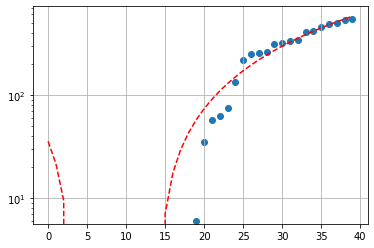

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 1859
New cases registered today: 68
New cases registered today in %: 3.8
Doubling time in the last five days: 14.3
Doubling time yesterday: 12.6
Trend of new cases (in %) in the last 5 days: 27.33


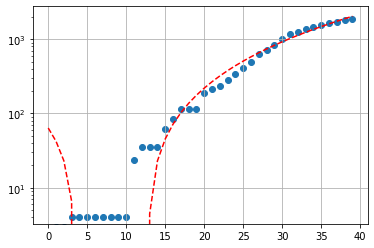

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.2262
Total cases up to today: 100
New cases registered today: 2
New cases registered today in %: 2.04
Doubling time in the last five days: 13.9
Doubling time yesterday: 6.6
Trend of new cases (in %) in the last 5 days: 28.21


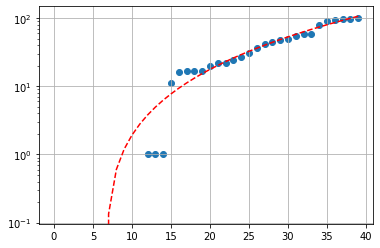

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.3077
Total cases up to today: 83
New cases registered today: 3
New cases registered today in %: 3.75
Doubling time in the last five days: 17.4
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 22.06


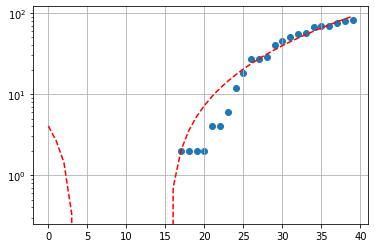

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.5021
Total cases up to today: 559
New cases registered today: 15
New cases registered today in %: 2.76
Doubling time in the last five days: 10.9
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 37.35


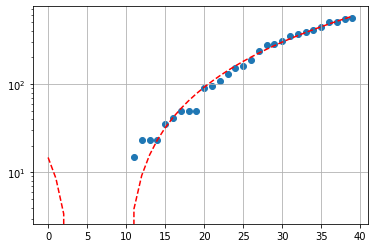

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 1.5293
Total cases up to today: 257
New cases registered today: 19
New cases registered today in %: 7.98
Doubling time in the last five days: 11.9
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 33.85


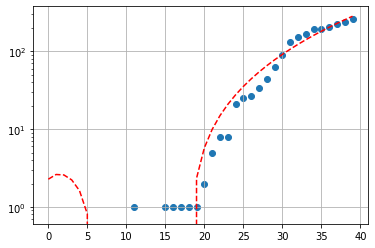

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.5293
Total cases up to today: 337
New cases registered today: 14
New cases registered today in %: 4.33
Doubling time in the last five days: 22.6
Doubling time yesterday: 23.7
Trend of new cases (in %) in the last 5 days: 16.61


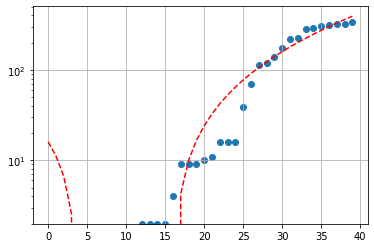

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.2287
Total cases up to today: 290
New cases registered today: 8
New cases registered today in %: 2.84
Doubling time in the last five days: 16.8
Doubling time yesterday: 17.8
Trend of new cases (in %) in the last 5 days: 22.88


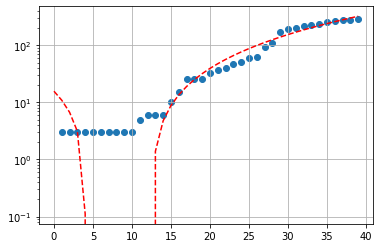

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.1431
Total cases up to today: 46
New cases registered today: 1
New cases registered today in %: 2.22
Doubling time in the last five days: 9.5
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 43.75


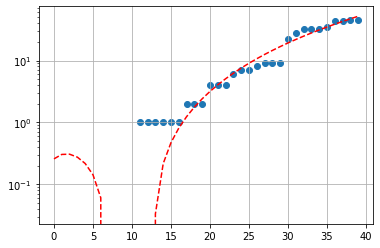

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.2631
Total cases up to today: 106
New cases registered today: 5
New cases registered today in %: 4.95
Doubling time in the last five days: 17.5
Doubling time yesterday: 18.8
Trend of new cases (in %) in the last 5 days: 21.84


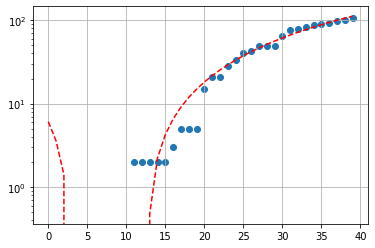

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.1864
Total cases up to today: 81
New cases registered today: 1
New cases registered today in %: 1.25
Doubling time in the last five days: 26.3
Doubling time yesterday: 13.6
Trend of new cases (in %) in the last 5 days: 14.08


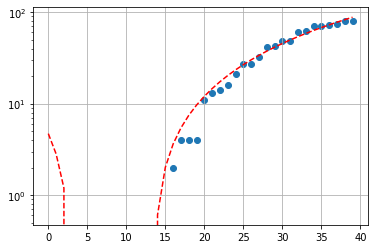

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 5499
New cases registered today: 226
New cases registered today in %: 4.29
Doubling time in the last five days: 12.0
Doubling time yesterday: 10.7
Trend of new cases (in %) in the last 5 days: 33.41


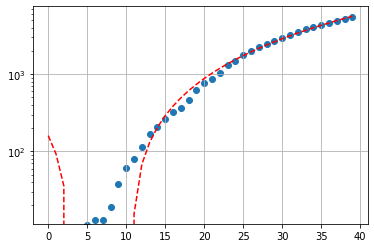

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 1.0396
Total cases up to today: 358
New cases registered today: 1
New cases registered today in %: 0.28
Doubling time in the last five days: 15.0
Doubling time yesterday: 12.7
Trend of new cases (in %) in the last 5 days: 26.06


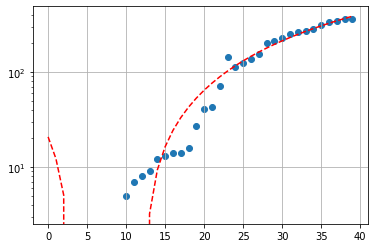

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 1.5211
Total cases up to today: 1543
New cases registered today: 124
New cases registered today in %: 8.74
Doubling time in the last five days: 7.3
Doubling time yesterday: 6.8
Trend of new cases (in %) in the last 5 days: 61.23


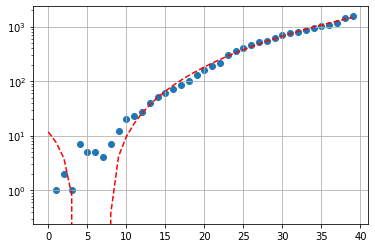

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.1836
Total cases up to today: 264
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 46.4
Doubling time yesterday: 28.7
Trend of new cases (in %) in the last 5 days: 7.76


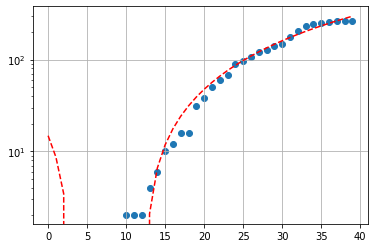

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 0.9101
Total cases up to today: 307
New cases registered today: 6
New cases registered today in %: 1.99
Doubling time in the last five days: 13.2
Doubling time yesterday: 11.1
Trend of new cases (in %) in the last 5 days: 30.08


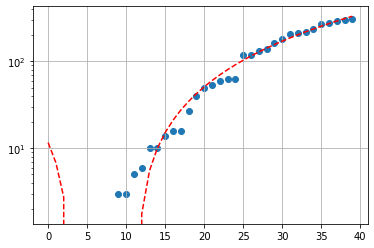

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 2.1613
Total cases up to today: 843
New cases registered today: 41
New cases registered today in %: 5.11
Doubling time in the last five days: 15.3
Doubling time yesterday: 13.3
Trend of new cases (in %) in the last 5 days: 25.45


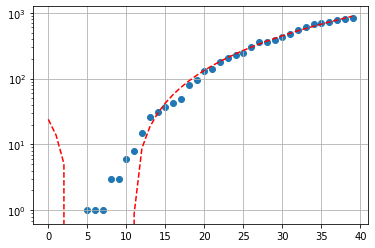

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 3.276
Total cases up to today: 644
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 13.0
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 30.63


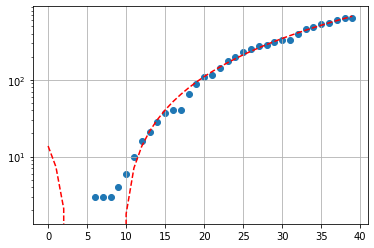

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.2303
Total cases up to today: 519
New cases registered today: 4
New cases registered today in %: 0.78
Doubling time in the last five days: 18.9
Doubling time yesterday: 13.4
Trend of new cases (in %) in the last 5 days: 20.14


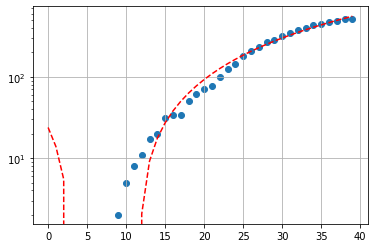

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.237
Total cases up to today: 361
New cases registered today: 15
New cases registered today in %: 4.34
Doubling time in the last five days: 22.3
Doubling time yesterday: 23.2
Trend of new cases (in %) in the last 5 days: 16.83


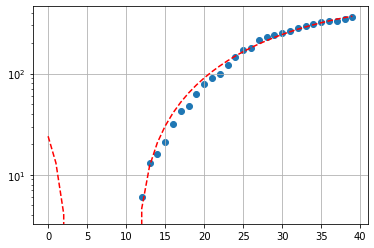

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 1.2686
Total cases up to today: 323
New cases registered today: 32
New cases registered today in %: 11.0
Doubling time in the last five days: 9.1
Doubling time yesterday: 11.8
Trend of new cases (in %) in the last 5 days: 46.15


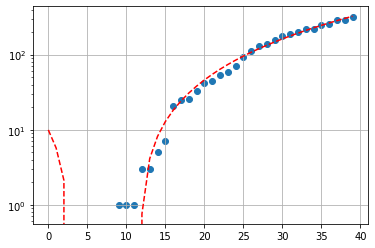

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.2559
Total cases up to today: 337
New cases registered today: 3
New cases registered today in %: 0.9
Doubling time in the last five days: 16.5
Doubling time yesterday: 9.9
Trend of new cases (in %) in the last 5 days: 23.44


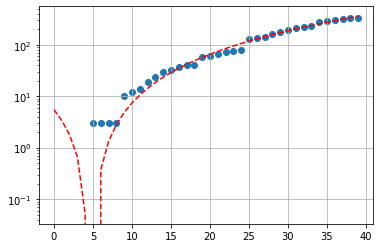

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 3.9157
Total cases up to today: 2109
New cases registered today: 106
New cases registered today in %: 5.29
Doubling time in the last five days: 12.4
Doubling time yesterday: 12.1
Trend of new cases (in %) in the last 5 days: 32.31


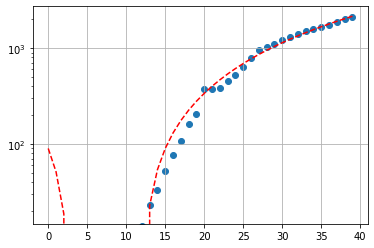

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 1141
New cases registered today: 51
New cases registered today in %: 4.68
Doubling time in the last five days: 24.9
Doubling time yesterday: 23.7
Trend of new cases (in %) in the last 5 days: 14.9


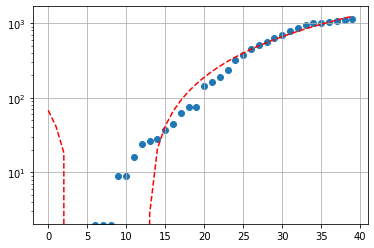

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.338
Total cases up to today: 884
New cases registered today: 40
New cases registered today in %: 4.74
Doubling time in the last five days: 26.3
Doubling time yesterday: 23.7
Trend of new cases (in %) in the last 5 days: 14.06


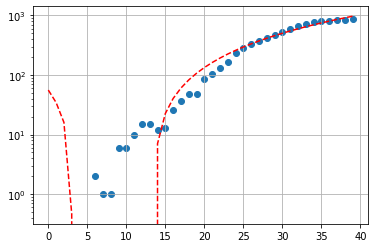

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 1.1261
Total cases up to today: 257
New cases registered today: 11
New cases registered today in %: 4.47
Doubling time in the last five days: 21.1
Doubling time yesterday: 24.1
Trend of new cases (in %) in the last 5 days: 17.89


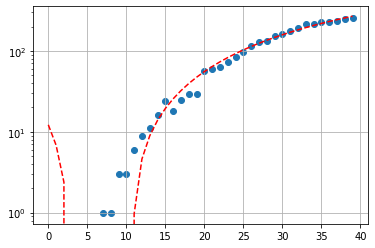

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 5.6666
Total cases up to today: 719
New cases registered today: 51
New cases registered today in %: 7.63
Doubling time in the last five days: 16.7
Doubling time yesterday: 12.9
Trend of new cases (in %) in the last 5 days: 23.12


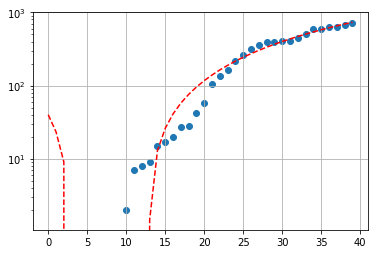

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 10212
New cases registered today: 346
New cases registered today in %: 3.51
Doubling time in the last five days: 14.9
Doubling time yesterday: 13.7
Trend of new cases (in %) in the last 5 days: 26.17


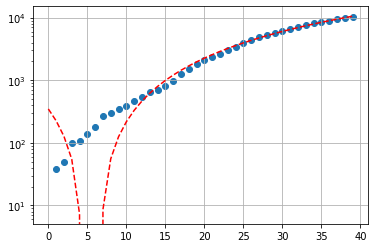

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 2.4249
Total cases up to today: 499
New cases registered today: 12
New cases registered today in %: 2.46
Doubling time in the last five days: 15.0
Doubling time yesterday: 12.3
Trend of new cases (in %) in the last 5 days: 26.01


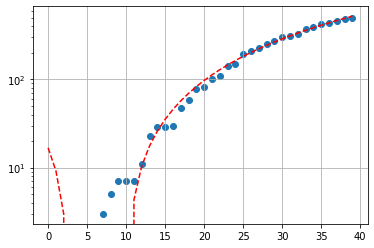

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 2.7268
Total cases up to today: 2553
New cases registered today: 64
New cases registered today in %: 2.57
Doubling time in the last five days: 18.8
Doubling time yesterday: 16.2
Trend of new cases (in %) in the last 5 days: 20.2


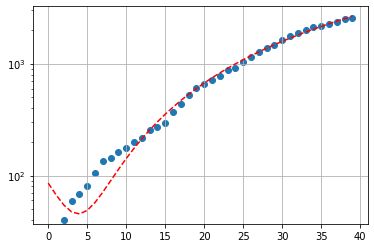

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 0.7544
Total cases up to today: 180
New cases registered today: 28
New cases registered today in %: 18.42
Doubling time in the last five days: 9.5
Doubling time yesterday: 15.8
Trend of new cases (in %) in the last 5 days: 44.0


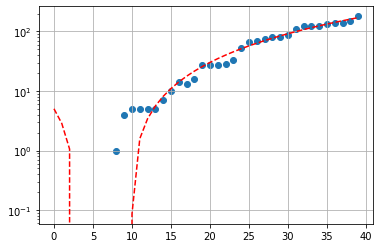

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 1.8703
Total cases up to today: 1657
New cases registered today: 51
New cases registered today in %: 3.18
Doubling time in the last five days: 20.7
Doubling time yesterday: 20.8
Trend of new cases (in %) in the last 5 days: 18.19


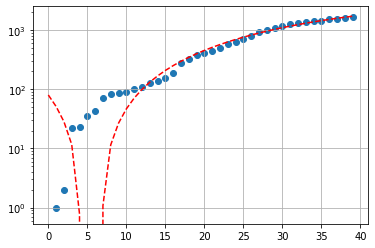

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 1.5463
Total cases up to today: 1321
New cases registered today: 28
New cases registered today in %: 2.17
Doubling time in the last five days: 16.2
Doubling time yesterday: 14.6
Trend of new cases (in %) in the last 5 days: 23.81


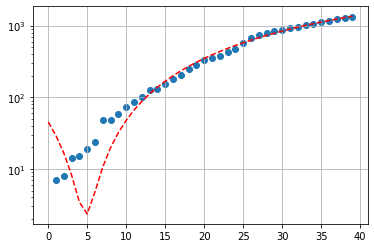

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 2.6998
Total cases up to today: 2488
New cases registered today: 83
New cases registered today in %: 3.45
Doubling time in the last five days: 12.3
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 32.62


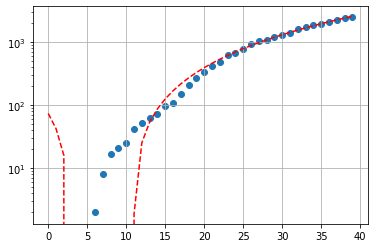

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 1.7501
Total cases up to today: 1514
New cases registered today: 80
New cases registered today in %: 5.58
Doubling time in the last five days: 11.0
Doubling time yesterday: 10.7
Trend of new cases (in %) in the last 5 days: 37.14


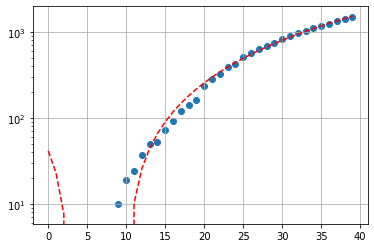

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')